In [109]:
import pandas as pd
import numpy as np
from itertools import combinations

import matplotlib.pyplot as plt
import random
import pygraphviz as pgv

ModuleNotFoundError: No module named 'pygraphviz'

# functions

In [2]:
""" general functions """
def make_fset(x, drop=True):
    if len(set(x.split(' '))) < 2:
        print(f"WARNING: Features for '{x}-{x}' (self-self PPI) detected ...")
        if drop == False:
            x1 = x.split(' ')[0]
            fset = frozenset({x1,x1})
            return(fset)
        else:
            return(None)
    else:
        x1 = x.split(' ')[0]
        x2 = x.split(' ')[1]
        fset = frozenset({x1,x2})
        return(fset)
    
def rescale(n, range1, range2):
    delta1 = range1[1] - range1[0]
    delta2 = range2[1] - range2[0]
    rs = (delta2 * (n - range1[0]) / delta1) + range2[0]
    return(rs)

def nonlabel_convert2na(x):
    if x == 'protein-containing complex':
        return(np.nan)
    return(x)

# input values

In [195]:
ppi_file = '../ppi_ml/results/ppi_predict/scored_interactions_all_LinearSVC_phyla.csv'
annot_file = '../ppi_ml/annotations/leca_eunog_annots_complete.030721.csv'
clst_file = '../ppi_ml/results/walktrap/LinearSVC_100feats_fdr10_4steps_nochloro.csv'
score_threshold = 0.437849144630267
opt_clst_n = 398

# format data

In [196]:
ppi_df = pd.read_csv(ppi_file)
fdr_df = ppi_df[ppi_df.ppi_score >= score_threshold]
an_df = pd.read_csv(annot_file)
clst_df_all = pd.read_csv(clst_file)
print(f'# total pairwise PPIs: {len(ppi_df)}')
print(f'# pairwise PPIs with FDR <=10%: {len(fdr_df)}')
print(f'# unique clustered proteins: {len(clst_df)}')

# total pairwise PPIs: 4491718
# pairwise PPIs with FDR <=10%: 109465
# unique clustered proteins: 1000


In [185]:
clst_df = clst_df_all.sample(1000)

In [186]:
cmplx_cols = ['go_cmplx_name','corum_cmplx_name','cp_cmplx_name']
cmplx_df = clst_df[['ID']+cmplx_cols]
for c in cmplx_cols:
    print(f'Checking column {c} ...')
    cmplx_df[c] = [nonlabel_convert2na(i) for i in cmplx_df[c]]
# label "unannotated" OGs (0=annotated to complex, 1=unannotated)
cmplx_df['cmplx_label_status'] = np.where(cmplx_df[cmplx_cols].isnull().all(1), 1, 0)
print(f"# of unannotated proteins: {len(cmplx_df[cmplx_df['cmplx_label_status']==1])}")

Checking column go_cmplx_name ...
Checking column corum_cmplx_name ...
Checking column cp_cmplx_name ...
# of unannotated proteins: 320


/tmp/ipykernel_959185/2758744355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmplx_df[c] = [nonlabel_convert2na(i) for i in cmplx_df[c]]
/tmp/ipykernel_959185/2758744355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmplx_df['cmplx_label_status'] = np.where(cmplx_df[cmplx_cols].isnull().all(1), 1, 0)


# networkx

In [187]:
import networkx as nx

In [188]:
node_df = cmplx_df[['ID','cmplx_label_status']].reset_index(drop=True)
all_ppis = [frozenset({i, j}) for i,j in list(combinations(node_df['ID'].to_list(), 2))]
fdr_df['fs'] = [make_fset(i) for i in fdr_df['ID']]
edge_df = fdr_df[fdr_df['fs'].isin(all_ppis)].reset_index(drop=True)

/tmp/ipykernel_959185/3625145132.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdr_df['fs'] = [make_fset(i) for i in fdr_df['ID']]



| hex code | color |
| :- | :- |
| "#E64B35" | bright red |
| "#3578E6" | bright blue |
| "#4BD2AC" | bright green |
| "#5530AA" | bright purple |
| "#665899" | muted purple |
| "#E6A435" | golden yellow |
| "#8A8A95" | dark grey |
| "#353540" | charcoal |
| "#1E1E1E" | black |

In [193]:
plt.switch_backend("GTK3Cairo")

# initialize network
protein_network = nx.Graph()
layout = 'kk'

# edge attribute(s)
for i in range(len(edge_df)):
    ppi = edge_df['ID'][i].split(' ')
    node1 =  ppi[0]
    node2 =  ppi[1]
    #weight = edge_df['n_phyla'][i]*3
    protein_network.add_edge(node1, node2)

# node attribute(s)
node_df['shape'] = ["1" if i == 1 else "o" for i in node_df['cmplx_label_status']]
node_df['degree'] = [protein_network.degree(i) for i in node_df['ID']]
node_df['degree'] = [0 if not type(i)==int else i for i in node_df['degree']]
node_dict = dict(zip(node_df['ID'], zip(node_df['degree'], node_df['shape'])))
for node in node_dict.keys():
    protein_network.add_node(node, color=node_dict[node][0], shape=node_dict[node][1])
    
# extract node colors and edge thickness attributes
node_colors = [protein_network.nodes[node]['color'] for node in protein_network.nodes()]
node_shapes = [protein_network.nodes[node]['shape'] for node in protein_network.nodes()]


# initialize plot
plt.figure(figsize=(20, 20))

G = protein_network.copy()

if layout=='spring':
    pos = nx.spring_layout(G)
elif layout=='kk':
    pos = nx.kamada_kawai_layout(G)
elif layout=='fr':
    pos=nx.fruchterman_reingold_layout(G)
    

nx.draw_networkx_edges(G, pos, alpha=0.66)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(node_dict.keys()),
    node_size=10,
    node_color=node_colors,
    node_shape="o",
    cmap=plt.cm.Reds_r,
)

plt.show()

ImportError: Cannot load backend 'GTK3Cairo' which requires the 'gtk3' interactive framework, as 'headless' is currently running

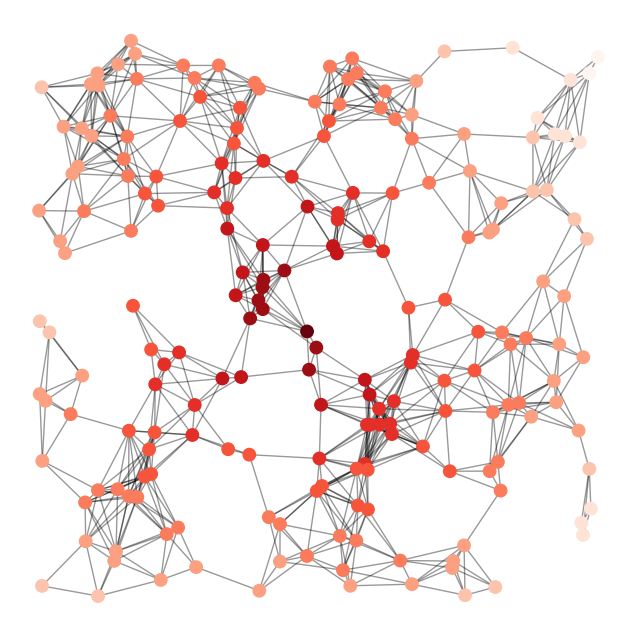

In [46]:
# Use seed when creating the graph for reproducibility
G = nx.random_geometric_graph(200, 0.125, seed=896803)
# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(G, "pos")

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5) ** 2 + (y - 0.5) ** 2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(G, ncenter))

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(p.keys()),
    node_size=80,
    node_color=list(p.values()),
    cmap=plt.cm.Reds_r,
)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()


# graph-tool

In [214]:
#import graph_tool.all as gt
from graph_tool.all import *
import matplotlib.pyplot as plt

plt.switch_backend("cairo")

In [201]:
edge_df = ppi_df[['ID','ppi_score','n_phyla','phyla']]
edge_df[['ID1','ID2']] = edge_df['ID'].str.split(' ', expand=True)
edge_df = edge_df.drop('ID', axis=1)
col_order = ['ID1','ID2','ppi_score','n_phyla','phyla']
edge_attr = [('weight','double'), ('conserved','int'), ('clades','string')]
edge_df = edge_df[col_order]
tuple_list = [tuple(row) for row in edge_df.itertuples(index=False, name=None)]

/tmp/ipykernel_959185/2013814575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_df[['ID1','ID2']] = edge_df['ID'].str.split(' ', expand=True)


In [215]:
g = Graph(directed=False)
g = add_edge_list(tuple_list, hashed=True, hash_type="string")

NameError: name 'add_edge_list' is not defined

In [209]:
g = gt.Graph(tuple_list, hashed=True, eprops=edge_attr, directed=False)

ValueError: Received property map for graph <Graph object, undirected, with 0 vertices and 0 edges, at 0x7fb515db2710> (base: <Graph object, undirected, with 0 vertices and 0 edges, at 0x7fb515db2710>), expected: <Graph object, undirected, with 0 vertices and 0 edges, 3 internal edge properties, at 0x7fb40b0897b0> (base: <Graph object, undirected, with 0 vertices and 0 edges, 3 internal edge properties, at 0x7fb40b0897b0>)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 11.5))
gt.graph_draw(g, g.vp.pos, vertex_size=1.5, mplfig=ax[0,0])